# LOAD Modules

In [1]:
%matplotlib inline
#%matplotlib widget
%load_ext autoreload
%autoreload 2


import numpy as np
from visualisations import eeg_sample_plot, events_distribution_plot
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader
from datasets import ChannelsVoltageDataset
from neural_nets.nn_models_getter import get_nn_model
from optimizers import get_optimizer
from utils_train import fit, test, plot_all_metrics, plot_val_metrics
from configs import configs_ozhan, configs_tim, configs_joaquin
from data_loader_creation import get_dataloader_objects
from classification_results import results_storer



# Select the configuration

In [2]:
""" USER: SELECT THE CONFIGURATION YOU NEED """
#myList = configs_tim.list_of_configs
#myList = configs_joaquin.list_of_configs
myList = configs_ozhan.list_of_configs

# Train

ConvNetOzhan_Adam 
-------------------------

We are not on the cluster...

Data is being loaded using MNE...


100%|██████████| 6/6 [00:32<00:00,  5.99s/it]


5418 matching events found
No baseline correction applied
...data loading with MNE was finished. 

Data is being augmented with gaussian noise...


100%|██████████| 4388/4388 [00:08<00:00, 528.49it/s]


...augmentation with gaussian noise is finished. 

cuda will be used for training of this model.
You have 2 GPUs for training!
Learning Rate:  0.001 

-> Epoch 1/50: train_loss: 2.1809, train_accuracy: 13.0242%, val_loss: 2.1743, val_accuracy: 14.1393%
-> Epoch 2/50: train_loss: 2.1711, train_accuracy: 13.8332%, val_loss: 2.1673, val_accuracy: 12.9098%
-> Epoch 3/50: train_loss: 2.1215, train_accuracy: 23.1996%, val_loss: 2.0741, val_accuracy: 29.3033%
-> Epoch 4/50: train_loss: 2.0350, train_accuracy: 32.1559%, val_loss: 2.0479, val_accuracy: 27.2541%
-> Epoch 5/50: train_loss: 1.9941, train_accuracy: 36.1896%, val_loss: 2.0101, val_accuracy: 32.5820%
-> Epoch 6/50: train_loss: 1.9683, train_accuracy: 38.4458%, val_loss: 2.0024, val_accuracy: 33.4016%
-> Epoch 7/50: train_loss: 1.9550, train_accuracy: 39.3573%, val_loss: 2.0032, val_accuracy: 34.6311%
-> Epoch 8/50: train_loss: 1.9473, train_accuracy: 39.4143%, val_loss: 1.9945, val_accuracy: 33.8115%
-> Epoch 9/50: train_loss: 1.9404

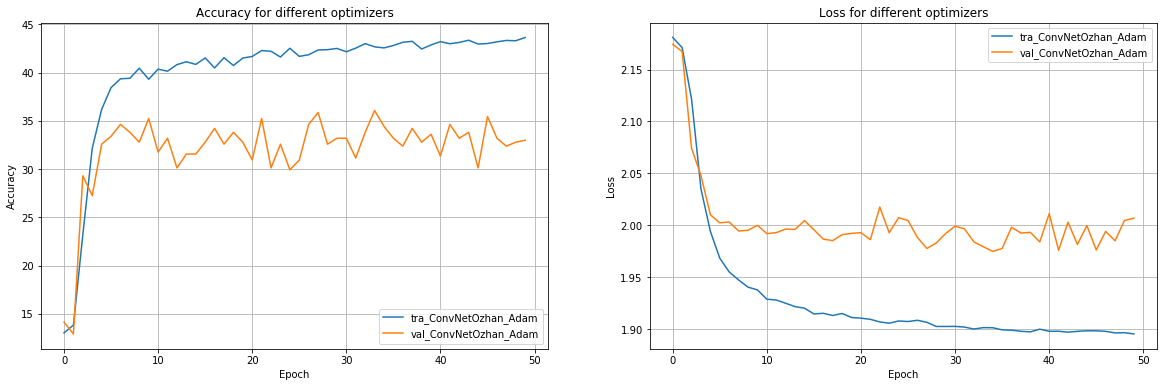

In [3]:
training_curves = {}

for my_cfg in myList:
    
    curve_name = my_cfg.nn_list[my_cfg.nn_selection_idx] + "_" + my_cfg.optimizer_list[my_cfg.optimizer_selection_idx]
    print(curve_name,"\n-------------------------\n", flush=True)
    
    """ PREPARE DATALOADERS """
    train_dl, val_dl, test_dl, input_dimension_, output_dimension_ = get_dataloader_objects(my_cfg)


    """CLASSIFICATION"""
    # Get the model
    model_untrained = get_nn_model(my_cfg.nn_list[my_cfg.nn_selection_idx], input_dimension=input_dimension_,
                                   output_dimension=output_dimension_, dropout=my_cfg.dropout_perc)

    # Get the optimizer
    optimizer = get_optimizer(my_cfg.optimizer_list[my_cfg.optimizer_selection_idx], my_cfg.learning_rate,
                              model_untrained.parameters(), my_cfg.momentum, my_cfg.weight_decay)

    # Train and show validation loss
    train_losses, train_accuracies, val_losses, val_accuracies, model_trained, time_spent_for_training_s =\
        fit(train_dl, val_dl, model_untrained, optimizer, my_cfg.loss_fn, my_cfg.num_of_epochs, \
            scheduler=my_cfg.scheduler, apply_early_stopping = my_cfg.use_early_stopping, \
            estop_patience=my_cfg.es_patience, curve_name = curve_name)
    
    
    curves = train_losses, train_accuracies, val_losses, val_accuracies, model_trained, time_spent_for_training_s
    
    
    training_curves[curve_name] = curves
    
    # Test the net
    print('\nPerformance on the test set:')
    test_loss, test_accuracy = test(model_trained, test_dl, my_cfg.loss_fn, print_loss=True)
    print('->test_loss: {:.4f}, test_accuracy: {:.4f}%'.format(test_loss, test_accuracy))


    # Store the results
    results_storer.store_results_for_plot(my_cfg,test_loss, test_accuracy, train_losses,
                                 train_accuracies, time_spent_for_training_s, val_losses, val_accuracies)

    results_storer.store_results(my_cfg, model_trained, optimizer, test_loss, test_accuracy, train_losses,
                                 train_accuracies, time_spent_for_training_s, val_losses, val_accuracies, test_dl)


plot_all_metrics(training_curves)